In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import io
#from google.colab import files
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import scipy.stats as ss
from sklearn.impute import SimpleImputer
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import cross_val_score

In [21]:
# Load and Define dataset:
start_date = datetime(2023,1,1)
end_date = datetime(2023,10,31)
data = pd.read_csv('INFOP7374_FeatureMart4GS.csv', index_col = [0])

In [22]:
start_date = datetime(2021,1,1)
end_date = datetime(2023,10,31)

In [23]:
data['Date'] = pd.to_datetime(data['Date'])
filter = (data['Date'] >= start_date) & (data['Date'] <= end_date)
data = data.loc[filter]
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Mkt-RF,SMB,HML,...,RIFSPPFAAD90NB,DCPN3M,DCPF1M,DCOILWTICO,DHHNGSP,USRECD,USRECDM,USRECDP,Yest_Close,stock_return
253,2021-01-04,351.670013,356.829987,346.410004,356.399994,356.399994,2015300,-1.41,0.16,0.58,...,0.13,0.10,0.09,47.47,2.60,0.0,0.0,0.0,348.029999,0.024050
254,2021-01-05,357.890015,369.440002,357.380005,366.500000,366.500000,2122900,0.86,1.32,0.49,...,0.15,0.11,0.10,49.78,2.77,0.0,0.0,0.0,356.399994,0.028339
255,2021-01-06,362.109985,367.600006,357.480011,363.250000,363.250000,1170800,0.79,3.15,3.94,...,0.13,0.11,NaN,50.45,2.76,0.0,0.0,0.0,366.500000,-0.008868
256,2021-01-07,366.869995,374.200012,364.600006,367.290009,367.290009,1103000,1.76,0.02,-0.83,...,0.14,0.10,NaN,50.63,2.81,0.0,0.0,0.0,363.250000,0.011122
257,2021-01-08,367.359985,370.540009,362.589996,365.459991,365.459991,994900,0.51,-1.01,-1.37,...,0.13,0.10,NaN,52.14,2.77,0.0,0.0,0.0,367.290009,-0.004982


In [24]:
# Copying the data into another variable
data2 = data.copy()
# Normalizing the data
for column in data.columns[1:]:
    if column != 'META_ADJ CLOSE':
        data2[column] = (data[column] - data[column].mean()) / data[column].std()

In [25]:
data2.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Mkt-RF',
       'SMB', 'HML', 'RMW', 'CMA', 'RF', 'ADS_Index', 'SP500', 'AMERIBOR',
       'T10YIE', 'T5YIE', 'BAMLH0A0HYM2', 'BAMLH0A0HYM2EY', 'DGS10', 'DGS1',
       'RIFSPPFAAD90NB', 'DCPN3M', 'DCPF1M', 'DCOILWTICO', 'DHHNGSP', 'USRECD',
       'USRECDM', 'USRECDP', 'Yest_Close', 'stock_return'],
      dtype='object')

In [30]:
# Splitting the dataset into X and y
X = data2.drop(columns=['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Yest_Close','stock_return']).fillna(method='bfill')  # Dropping non-numeric columns
X = sm.add_constant(X)
y = data2['Adj Close']

In [31]:
# Check for null values in each column
null_columns = np.isnan(X).any(axis=0)
null_columns

const             False
Volume            False
Mkt-RF            False
SMB               False
HML               False
RMW               False
CMA               False
RF                False
ADS_Index         False
SP500             False
AMERIBOR          False
T10YIE            False
T5YIE             False
BAMLH0A0HYM2      False
BAMLH0A0HYM2EY    False
DGS10             False
DGS1              False
RIFSPPFAAD90NB    False
DCPN3M            False
DCPF1M             True
DCOILWTICO        False
DHHNGSP           False
USRECD             True
USRECDM            True
USRECDP            True
dtype: bool

In [32]:
imputer = SimpleImputer(strategy='median')
X = imputer.fit_transform(X)

In [33]:
print('Shape of X:', X.shape)
print('Shape of y:', y.shape)

Shape of X: (712, 22)
Shape of y: (712,)


In [34]:
# Check for null values in each column
null_columns = np.isnan(X).any(axis=0)
null_columns

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False])

In [35]:
# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [37]:
# ------------------------------------------------------------------------------
# Benchmark Model
# ------------------------------------------------------------------------------

benchmark_prep = sm.OLS(y, X).fit()
benchmark_prep.summary()

# Create a boolean mask with the same number of columns as X
boolean_mask_benchmark = np.abs(benchmark_prep.tvalues) >= 1.96

# Select columns from X based on the boolean mask
x_benchmark = X[:, boolean_mask_benchmark]

# Get the column names from the original DataFrame (data2)
column_names = data2.columns

# Extract selected features based on the benchmark model mask
selected_features_benchmark = [column_names[i] for i, mask in enumerate(boolean_mask_benchmark) if mask]

# Continue with the rest of your code
benchmark = sm.OLS(y, x_benchmark).fit()
print(benchmark.summary())
y_hat_benchmark1 = benchmark.predict(x_benchmark)
corr_benchmark1 = ss.pearsonr(y_hat_benchmark1, y)[0]
print('\nBenchmark: corr(Y, Y_pred) = ' + str(corr_benchmark1))
print('Hard Thresholding selected ' + str(np.sum(boolean_mask_benchmark)) + ' features in the benchmark model.')
print('Selected features in the benchmark model:', selected_features_benchmark)

                                 OLS Regression Results                                
Dep. Variable:              Adj Close   R-squared (uncentered):                   0.668
Model:                            OLS   Adj. R-squared (uncentered):              0.664
Method:                 Least Squares   F-statistic:                              141.5
Date:                Thu, 14 Dec 2023   Prob (F-statistic):                   6.61e-161
Time:                        21:16:26   Log-Likelihood:                         -616.75
No. Observations:                 712   AIC:                                      1253.
Df Residuals:                     702   BIC:                                      1299.
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [38]:
# ------------------------------------------------------------------------------
# Factor Selection using Ridge Regression
# ------------------------------------------------------------------------------
# Motivation: the model sets the objective function to be the
# sum of squared residuals from OLS + penalty function
# that penalizes squared values of beta. A minimization process squeezes
# the small beta values close to 0.
# a represents the obj function's sensitivity to the penalty term
# Steo 1. run Ridge Regression and obtain coefficients
# Step 2. remove features with coefficients close to 0 and run OLS
a = 0.5
model2_prep = Ridge(alpha=a, fit_intercept=False).fit(X, y)

# Create a boolean mask for selecting columns based on the coefficients
boolean_mask = np.abs(model2_prep.coef_) >= 0.001

# Get the column names from the original DataFrame (data2)
column_names = data2.columns

# Select columns from X based on the boolean mask
x = X[:, boolean_mask]

# Continue with the rest of your code
model2 = sm.OLS(y, x).fit()
print(model2.summary())
y_pred_model2 = model2.predict(x)
corr_model2 = ss.pearsonr(y_pred_model2, y)[0]

# Print the selected features using the column_names list
selected_features = [column_names[i] for i, mask in enumerate(boolean_mask) if mask]
print('model 2 Ridge Regression: corr (Y, Y_pred) = ' + str(corr_model2))
print('Ridge Regression selected ' + str(len(selected_features)) + ' features: ', selected_features)

                            OLS Regression Results                            
Dep. Variable:              Adj Close   R-squared:                       0.683
Model:                            OLS   Adj. R-squared:                  0.674
Method:                 Least Squares   F-statistic:                     70.95
Date:                Thu, 14 Dec 2023   Prob (F-statistic):          1.57e-156
Time:                        21:16:32   Log-Likelihood:                -600.26
No. Observations:                 712   AIC:                             1245.
Df Residuals:                     690   BIC:                             1345.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1916      0.118     -1.624      0.1

In [39]:
selected_features

['Date',
 'Open',
 'High',
 'Low',
 'Close',
 'Adj Close',
 'Volume',
 'Mkt-RF',
 'SMB',
 'HML',
 'RMW',
 'CMA',
 'RF',
 'ADS_Index',
 'SP500',
 'AMERIBOR',
 'T10YIE',
 'T5YIE',
 'BAMLH0A0HYM2',
 'BAMLH0A0HYM2EY',
 'DGS10',
 'DGS1']

In [40]:
# Define the number of top features to keep
k = 25  # Change this to the desired number of top features

# Get the coefficients of the Ridge model (feature importance)
coefficients = model2_prep.coef_

# Create a DataFrame to associate coefficients with feature names
feature_importance_df = pd.DataFrame({'Feature Name': selected_features, 'Coefficient': coefficients})

# Sort the features by absolute coefficient value in descending order
feature_importance_df = feature_importance_df.reindex(feature_importance_df['Coefficient'].sort_values(ascending=False).index)
print(feature_importance_df)

      Feature Name  Coefficient
17           T5YIE     0.990767
9              HML     0.795574
11             CMA     0.702859
7           Mkt-RF     0.380705
21            DGS1     0.202088
13       ADS_Index     0.142813
14           SP500     0.127977
3              Low     0.069940
5        Adj Close     0.061497
6           Volume     0.038280
19  BAMLH0A0HYM2EY     0.003376
15        AMERIBOR    -0.015532
1             Open    -0.020724
8              SMB    -0.031896
2             High    -0.032241
4            Close    -0.074536
0             Date    -0.097570
18    BAMLH0A0HYM2    -0.190469
10             RMW    -0.241512
20           DGS10    -0.380549
12              RF    -0.714458
16          T10YIE    -1.164351


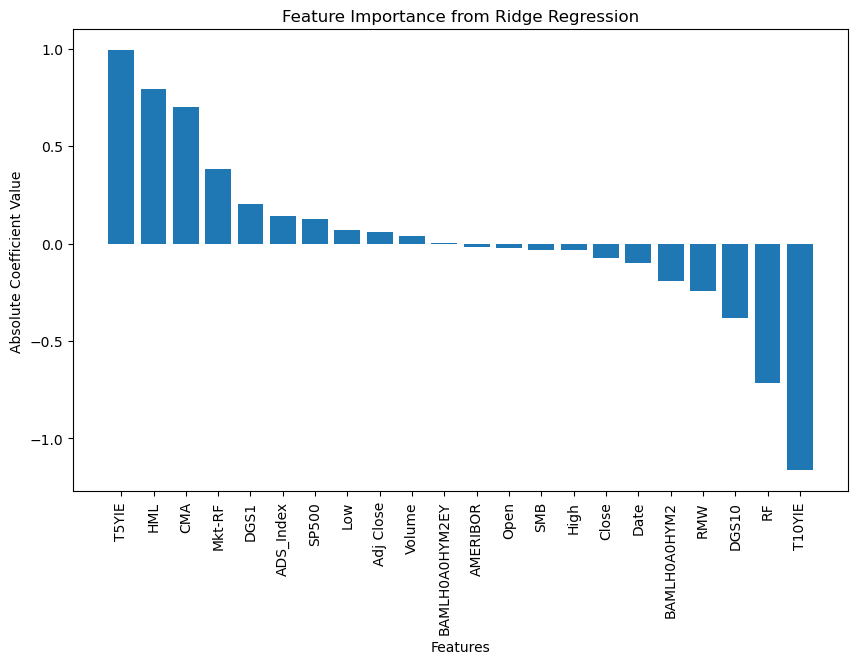

In [41]:
feature_importance_df.sort_values(by='Coefficient', ascending=False, inplace=True)

# Plotting the feature importances
plt.figure(figsize=(10, 6))
plt.bar(feature_importance_df['Feature Name'], feature_importance_df['Coefficient'])
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Absolute Coefficient Value')
plt.title('Feature Importance from Ridge Regression')
plt.show()

In [42]:
# Select the top k features
top_features = feature_importance_df['Feature Name'][:k]
print(top_features)

17             T5YIE
9                HML
11               CMA
7             Mkt-RF
21              DGS1
13         ADS_Index
14             SP500
3                Low
5          Adj Close
6             Volume
19    BAMLH0A0HYM2EY
15          AMERIBOR
1               Open
8                SMB
2               High
4              Close
0               Date
18      BAMLH0A0HYM2
10               RMW
20             DGS10
12                RF
16            T10YIE
Name: Feature Name, dtype: object


In [43]:
# Filter X_train and X_test to include only the top features
X_selected = X[:, [selected_features.index(feature) for feature in top_features]]
X_train_selected = X_train[:, [selected_features.index(feature) for feature in top_features]]
X_test_selected = X_test[:, [selected_features.index(feature) for feature in top_features]]

In [44]:
#####################################################
# Hyperparameter Tuning
#####################################################

# Define a range of alpha values to test
alphas = np.logspace(-6, 6, 200)

# Replace Ridge with RidgeCV
model2_prep = RidgeCV(alphas=alphas, fit_intercept=False, store_cv_values=True).fit(X_train_selected, y_train)

# Print the best alpha value
print("Best alpha value:", model2_prep.alpha_)

# Optionally, retrain Ridge model using the best alpha value
model2 = Ridge(alpha=model2_prep.alpha_, fit_intercept=False).fit(X_train_selected, y_train)

Best alpha value: 3.2550885998350565


In [45]:
y_hat = model2.predict(X_test_selected)
y_hat

array([-0.60202318,  0.76922242,  1.21006293,  1.28810813, -0.65860378,
       -0.46622613, -1.70228337, -1.09747837, -1.72485792,  0.26778894,
        1.54946275,  1.59909188, -0.15407403, -1.6724551 ,  0.26275011,
       -0.58817355,  0.77002253, -0.6370335 , -0.77261754,  0.86566173,
        0.27474819,  0.3792465 , -0.60024864, -1.07466507,  0.91525643,
       -1.03396843, -0.19618491, -0.8620226 , -0.20579906, -0.1586373 ,
       -1.24609007, -0.7596488 , -0.5172224 , -0.83174841, -0.73278449,
        0.85796831, -0.72221795,  0.29609203, -1.75385716,  0.84338509,
        0.64469788,  1.43346184, -0.35075076,  0.31358657,  0.29362077,
        0.15430375,  0.00323788, -0.55432708, -0.63148779, -0.18876985,
       -0.42567645,  0.22457354,  0.79121396,  0.97966322,  0.76744568,
       -0.15117508, -0.08974203, -0.82647177, -1.30423372, -0.18469255,
       -0.58391597, -0.84538771, -0.42467985,  0.06637033, -1.09177267,
        0.09892229, -0.46516821, -0.21273736,  1.08460533,  0.24

In [46]:
###############################################################################
# Cross Validation:
###############################################################################

# Perform cross-validation
cv_scores = cross_val_score(model2, X, y, cv=5, scoring='neg_mean_squared_error')

# Calculate the mean score
mean_cv_score = np.mean(cv_scores)

# Print the results
print("Mean Cross-Validation Score:", mean_cv_score)

# Evaluate Model:
# Calculate the mean squared error and convert it back to positive
mse_scores = -cv_scores
mean_mse = np.mean(mse_scores)
std_mse = np.std(mse_scores)

rmse = np.mean(np.sqrt(np.abs(cv_scores)))
std_rmse = np.std(np.sqrt(np.abs(cv_scores)))
print(f'MEAN of Mean Squared Error: {mean_mse}')
print(f'STD of RMSE Squared Error: {std_rmse}')
print(f'Root Mean Squared Error on Test Set: {rmse}')

Mean Cross-Validation Score: -0.9758069052087238
MEAN of Mean Squared Error: 0.9758069052087238
STD of RMSE Squared Error: 0.28907206707941613
Root Mean Squared Error on Test Set: 0.9445868119146896


**There is no overfitting in the Ridge Model.**

In [47]:
## Model Evaluation

rmse = mean_squared_error(y_test, y_hat, squared=False)
rmse

0.5891040722044093

## Trading Signals

In [48]:
# Creating input data for month of October 2023
X_updated = X_selected[-22:]
y_updated = y[-22:]

In [49]:
# Predicting using XGBoost
y_pred = model2.predict(X_updated)
#y_pred

In [50]:
def TRADING_RULE(P_hat, P, options):
    if options == 'BUY HOLD':
        return TRADING_RULE_1(P)
    elif options == 'LONG SHORT':
        return TRADING_RULE_2(P_hat, P)
    elif options == 'DAY TRADE':
        return TRADING_RULE_3(P_hat, P)

def TRADING_RULE_1(P):
    T = P.shape[0]
    signal = np.zeros(T)
    signal[0] = 1
    signal[-1] = -1
    return signal

def TRADING_RULE_2(P_hat, P):
    T = P.shape[0]
    signal = np.zeros(T)
    for t in range(1, T):
        if (P_hat[t-1] > P[t-1]) + (P_hat[t] < P[t]) == 2:  # FORCAST > OPEN: LONG
            signal[t] = 1
        elif (P_hat[t-1] < P[t-1]) + (P_hat[t] > P[t]) == 2:  # FORECAST < OPEN: SHORT
            signal[t] = -1
    return signal

def TRADING_RULE_3(P_hat, P):
    T = P.shape[0]
    signal = np.zeros(T)
    for t in range(1, T):
        if P_hat[t] > P[t]:  # FORCAST > OPEN: LONG
            signal[t] = 1
        elif P_hat[t] < P[t]:  # FORECAST < OPEN: SHORT
            signal[t] = -1
    return signal

In [51]:
def calculate_profit_loss(signal, price):
    T = len(signal)
    position = np.zeros(T)
    balance = np.zeros(T)
    position[1:] = np.diff(signal)  # Buy (1) or Sell (-1) at each signal change
    balance[0] = 10000  # Initial balance
    for t in range(1, T):
        balance[t] = balance[t - 1] + position[t] * price[t]
    return balance

# Example usage:
# Assume 'price' is a numpy array or list containing the asset prices over time
# and 'signal' is the trading signal generated by TRADING_RULE function.

# Example price data
price = y_updated.values

# Example trading signal
signal = TRADING_RULE(y_pred, y_updated.values, 'DAY TRADE')

# Calculate profit and loss
profit_loss = calculate_profit_loss(signal, price)

# Display the results
print("Trading Signal:", signal)
print("Asset Prices:", price)
print("Profit and Loss:", profit_loss)

Trading Signal: [ 0. -1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1.]
Asset Prices: [0.73925228 0.41176706 0.45146249 0.23178514 0.38650659 0.50875008
 0.51754582 0.52498837 0.53807013 0.62264799 1.50113027 1.41767984
 1.25235794 1.03989875 1.03155384 1.18131268 1.20183699 1.05140156
 0.86916408 0.82856699 0.93975851 0.97877734]
Profit and Loss: [10000.          9999.58823294 10000.49115792 10000.49115792
 10000.49115792 10000.49115792 10000.49115792 10000.49115792
 10000.49115792  9999.24586194  9999.24586194  9999.24586194
  9999.24586194  9999.24586194  9999.24586194  9999.24586194
  9999.24586194  9999.24586194  9999.24586194  9999.24586194
  9999.24586194  9999.24586194]


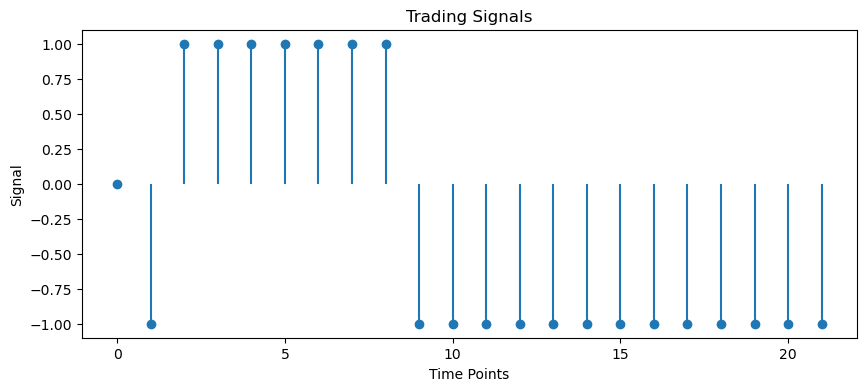

In [52]:
trading_signals = signal

time_points = np.arange(len(trading_signals))

# Plot the trading signals
plt.figure(figsize=(10, 4))
plt.stem(time_points, trading_signals, basefmt=" ", markerfmt="o", linefmt="-")
plt.title('Trading Signals')
plt.xlabel('Time Points')
plt.ylabel('Signal')
plt.show()

In [53]:
Total_Profit = profit_loss[-1] - profit_loss[0]
print('Total Profit: $'+ str(np.round(Total_Profit)))

Total Profit: $-1.0
